In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import torch

import copy
import traceback
import datetime
import joblib
import re
import os
import random
import string
from collections import Counter

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import matplotlib.pyplot as plt
%matplotlib inline

from tqdm.notebook import tqdm

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize
import pymorphy2
from sklearn.base import BaseEstimator, TransformerMixin

In [2]:
class Config:
    seed = 42
    positive_file = "../data/positive.csv"
    negative_file = "../data/negative.csv"
    russian_stop_words = "../data/russian_stop_words.txt"
    english_stop_words = "../data/english_stop_words.txt"
    test_size = 0.3
    
config = Config()

In [3]:
def init_random_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic=True

In [4]:
init_random_seed(config.seed)

База данных состоит из 12 столбцов:

1. id: уникальный номер сообщения в системе twitter;
2. tdate: дата публикации сообщения (твита);
3. tmane: имя пользователя, опубликовавшего сообщение;
4. ttext:  текст сообщения (твита);
5. ttype: поле в котором в дальнейшем будет указано к кому классу относится твит (положительный, отрицательный, нейтральный);
6. trep: количество реплаев к данному сообщению. В настоящий момент API твиттера не отдает эту информацию;
7. trtw: число ретвитов
8. tfav: число сколько раз данное сообщение было добавлено в избранное другими пользователями;
9. tstcount: число всех сообщений пользователя в сети twitter;
10. tfoll: количество фоловеров пользователя (тех людей, которые читают пользователя);
11. tfrien: количество друзей пользователя (те люди, которых читает пользователь);
12. listcount: количество листов-подписок в которые добавлен твиттер-пользователь.

In [5]:
column_names = ["id", "tdate", "tmane", "ttext", "ttype", "trep", "trtw", "tfav", "tstcount", "tfoll", "tfrien", "listcount"]
positive_df = pd.read_csv(config.positive_file, sep=";", names=column_names, index_col=False)
negative_df = pd.read_csv(config.negative_file, sep=";", names=column_names, index_col=False)

In [6]:
positive_df.head()

,id,tdate,tmane,ttext,ttype,trep,trtw,tfav,tstcount,tfoll,tfrien,listcount
0,408906692374446080,1386325927,pleease_shut_up,"@first_timee хоть я и школота, но поверь, у на...",1,0,0,0,7569,62,61,0
1,408906692693221377,1386325927,alinakirpicheva,"Да, все-таки он немного похож на него. Но мой ...",1,0,0,0,11825,59,31,2
2,408906695083954177,1386325927,EvgeshaRe,RT @KatiaCheh: Ну ты идиотка) я испугалась за ...,1,0,1,0,1273,26,27,0
3,408906695356973056,1386325927,ikonnikova_21,"RT @digger2912: ""Кто то в углу сидит и погибае...",1,0,1,0,1549,19,17,0
4,408906761416867842,1386325943,JumpyAlex,@irina_dyshkant Вот что значит страшилка :D\nН...,1,0,0,0,597,16,23,1


In [7]:
negative_df.head()

,id,tdate,tmane,ttext,ttype,trep,trtw,tfav,tstcount,tfoll,tfrien,listcount
0,408906762813579264,1386325944,dugarchikbellko,на работе был полный пиддес :| и так каждое за...,-1,0,0,0,8064,111,94,2
1,408906818262687744,1386325957,nugemycejela,"Коллеги сидят рубятся в Urban terror, а я из-з...",-1,0,0,0,26,42,39,0
2,408906858515398656,1386325966,4post21,@elina_4post как говорят обещаного три года жд...,-1,0,0,0,718,49,249,0
3,408906914437685248,1386325980,Poliwake,"Желаю хорошего полёта и удачной посадки,я буду...",-1,0,0,0,10628,207,200,0
4,408906914723295232,1386325980,capyvixowe,"Обновил за каким-то лешим surf, теперь не рабо...",-1,0,0,0,35,17,34,0


In [8]:
# Смена метки класса для отрицательной эмоциональной окраски
negative_df["ttype"] = 0

In [9]:
df = pd.concat([negative_df, positive_df])
df.shape, negative_df.shape, positive_df.shape

((226834, 12), (111923, 12), (114911, 12))

In [10]:
df = df[["ttext", "ttype"]]
df.shape

(226834, 2)

In [11]:
def word_count(sentence):
    return len(sentence.split())

In [12]:
df['word_count'] = df['ttext'].apply(word_count)
df.head(3)

,ttext,ttype,word_count
0,на работе был полный пиддес :| и так каждое за...,0,16
1,"Коллеги сидят рубятся в Urban terror, а я из-з...",0,14
2,@elina_4post как говорят обещаного три года жд...,0,7


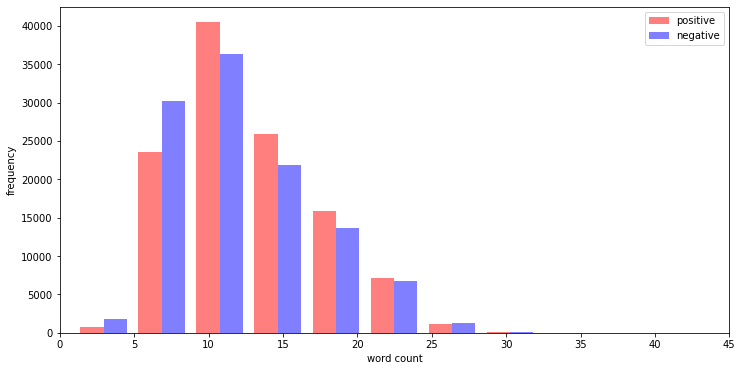

In [13]:
# plot word count distribution for both positive and negative sentiments
x = df['word_count'][df.ttype == 1]
y = df['word_count'][df.ttype == 0]
plt.figure(figsize=(12,6))
plt.xlim(0,45)
plt.xlabel('word count')
plt.ylabel('frequency')
g = plt.hist([x, y], color=['r','b'], alpha=0.5, label=['positive','negative'])
plt.legend(loc='upper right')

In [14]:
# get most common words in training dataset
all_words = []
for line in list(df['ttext']):
    words = line.lower().split()
    for word in words:
        all_words.append(word)
    
    
Counter(all_words).most_common(10)

[('не', 72372),
 ('я', 59961),
 ('и', 58158),
 ('в', 55969),
 ('на', 37461),
 ('rt', 37228),
 ('а', 29973),
 ('что', 28316),
 ('с', 27249),
 ('у', 21573)]

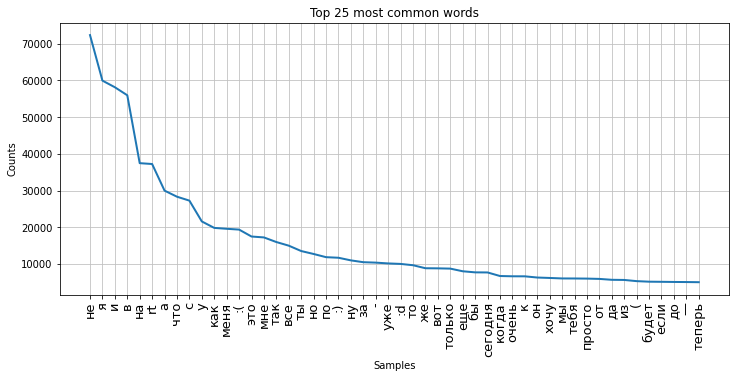

In [15]:
# plot word frequency distribution of first few words
plt.figure(figsize=(12,5))
plt.title('Top 25 most common words')
plt.xticks(fontsize=13, rotation=90)
fd = nltk.FreqDist(all_words)
fd.plot(50, cumulative=False)

Text(0.5, 1.0, 'log-log plot of words frequency')

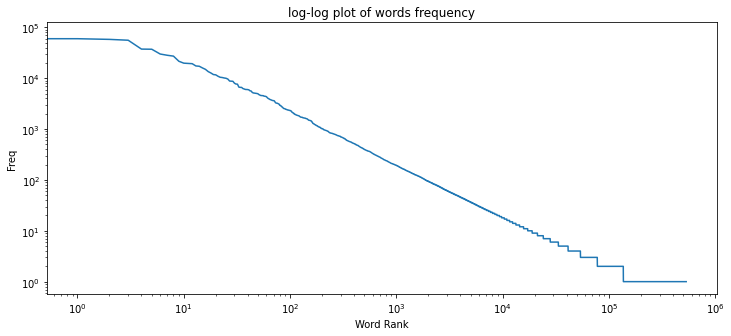

In [16]:
# log-log plot
word_counts = sorted(Counter(all_words).values(), reverse=True)
plt.figure(figsize=(12,5))
plt.loglog(word_counts, linestyle='-', linewidth=1.5)
plt.ylabel("Freq")
plt.xlabel("Word Rank")
plt.title('log-log plot of words frequency')

In [17]:
def get_stop_words():
    stopwords = nltk.corpus.stopwords.words('russian')
    stopwords_delete = ['хорошо', 'лучше', 'может', 'никогда', 'нельзя', 'всегда']
    stopwords_add = ['это', 'который', "хотя", "кстати"]
    return [word for word in stopwords if word not in stopwords_delete] + \
        stopwords_add + \
        ['rt', 'via'] + \
        list(string.punctuation) + \
        ['–', '—', '"', "¿", "¡"]

In [19]:
# helper function to clean tweets
def process_tweet(tweet):
    tweet = tweet.lower()
    # Remove HTML special entities (e.g. &amp;)
    tweet = re.sub(r'\&\w*;', '', tweet)
    #Convert @username to AT_USER
    tweet = re.sub('@[^\s]+','',tweet)
    # Remove tickers
    tweet = re.sub(r'\$\w*', '', tweet)
    # Remove hyperlinks
    tweet = re.sub(r'https?:\/\/.*\/\w*', '', tweet)
    # Remove hashtags
    tweet = re.sub(r'#\w*', '', tweet)
    # Remove Punctuation and split 's, 't, 've with a space for filter
    tweet = re.sub(r'[' + string.punctuation.replace('@', '') + '™…]+', ' ', tweet)
    # Remove words with 2 or fewer letters
    tweet = re.sub(r'\b\w{1,2}\b', '', tweet)
    # Remove whitespace (including new line characters)
    tweet = re.sub(r'\s\s+', ' ', tweet)
    # Remove single space remaining at the front of the tweet.
    tweet = tweet.lstrip(' ')
    # Check characters to see if they are in punctuation
    tweet = [char for char in tweet if char not in string.punctuation and not char.isnumeric() ]
    # Remove characters beyond Basic Multilingual Plane (BMP) of Unicode:
    tweet = ''.join(c for c in tweet if c <= '\uFFFF') 
    # Now just remove any stopwords
    stop_words = get_stop_words()
    return [word for word in tweet.split() if word not in stop_words and not word.isdigit()]
    return tweet

In [20]:
%%time

# clean dataframe's text column
df['message'] = df['ttext'].apply(process_tweet)

CPU times: user 45.2 s, sys: 2.32 s, total: 47.5 s
Wall time: 47.5 s


In [21]:
df.head()

,ttext,ttype,word_count,message
0,на работе был полный пиддес :| и так каждое за...,0,16,"[работе, полный, пиддес, каждое, закрытие, мес..."
1,"Коллеги сидят рубятся в Urban terror, а я из-з...",0,14,"[коллеги, сидят, рубятся, urban, terror, долба..."
2,@elina_4post как говорят обещаного три года жд...,0,7,"[говорят, обещаного, года, ждут]"
3,"Желаю хорошего полёта и удачной посадки,я буду...",0,11,"[желаю, хорошего, полёта, удачной, посадки, бу..."
4,"Обновил за каким-то лешим surf, теперь не рабо...",0,10,"[обновил, каким, лешим, surf, работает, просто..."


In [22]:
cache = {}
morph = pymorphy2.MorphAnalyzer()

# Фильтруем по части речи и возвращаем только начальную форму.
def lemmatize(tokens):
    words = []
    for token in tokens:
        # Если токен уже был закеширован, быстро возьмем результат из кэша.
        if token in cache.keys():
            words.append(cache[token])
        # Слово еще не встретилось, будем проводить медленный морфологический анализ.
        else:
            result = morph.parse(token)
            if result[0].tag.POS != None:   
                word = result[0].normal_form
                # Отправляем слово в результат, ...
                words.append(word)
                # ... и кешируем результат его разбора.
                cache[token] = word
            if 'LATN' in result[0].tag:
                word = result[0].normal_form
                words.append(word)
                cache[token] = word    
    return ' '.join(words)

In [23]:
%%time

df['message'] = df['message'].apply(lemmatize)

CPU times: user 39.2 s, sys: 2.1 ms, total: 39.2 s
Wall time: 39.2 s


In [24]:
df.head()

,ttext,ttype,word_count,message
0,на работе был полный пиддес :| и так каждое за...,0,16,работа полный пиддес каждый закрытие месяц сви...
1,"Коллеги сидят рубятся в Urban terror, а я из-з...",0,14,коллега сидеть рубиться urban terror долбать в...
2,@elina_4post как говорят обещаного три года жд...,0,7,говорят обещаной год ждать
3,"Желаю хорошего полёта и удачной посадки,я буду...",0,11,желать хороший полёт удачный посадка быть очен...
4,"Обновил за каким-то лешим surf, теперь не рабо...",0,10,обновить какой леший surf работать простоплеер


In [25]:
df_classfier = df[["message", "ttype"]]

In [26]:
df_classfier.to_csv("../data/preprocessed_text_v1.csv", index=False)